In [64]:
from pymongo import ASCENDING, GEOSPHERE, MongoClient
import pandas as pd
from alive_progress import alive_bar
from shapely.geometry import Point, mapping
from keplergl import KeplerGl
import shapely
import json
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import geopandas as gpd
from h3 import h3
import math
import sklearn
import numpy as np
import time

In [65]:
client = MongoClient('mongodb://localhost:27017/')
db = client.osmDataDB
coll_results = db.experimentsResults
coll_results_bak = db.experimentsResultsBak
coll_results_nn = db.experimentsResultsNN

In [66]:
results_new = [r for r in coll_results.find({'city': { '$in': ['Warszawa', 'Wrocław', 'Poznań']}})]

In [67]:
results_bak = [r for r in coll_results_bak.find({'city': { '$in': ['Warszawa', 'Wrocław', 'Poznań']}})]

In [68]:
results_nn = [r for r in coll_results_nn.find({'city': { '$in': ['Warszawa', 'Wrocław', 'Poznań']}})]

In [69]:
print(len(results_new), len(results_nn), len(results_bak))

5544 624 5071


In [70]:
results = results_new

In [71]:
def exists_result(res):
    city = res["city"]
    resolution = res["resolution"]
    inbalance_ratio = res["inbalance_ratio"]
    embedding_cls = res["embedding_cls"]
    neighbours = res["neighbours"]
    neighbour_embedding_cls = res["neighbour_embedding_cls"]
    x_processing = res["x_processing"]
    return any([r["city"] == city and r["resolution"] == resolution and r["inbalance_ratio"] == inbalance_ratio and r["embedding_cls"] == embedding_cls and r["neighbours"] == neighbours and r["neighbour_embedding_cls"] == neighbour_embedding_cls and r["x_processing"] == x_processing for r in results])

In [72]:
for result in tqdm(results_bak):
    if not exists_result(result):
        results.append(result)
results.extend(results_nn)
len(results)

100%|██████████| 5071/5071 [00:10<00:00, 483.85it/s]


7502

In [73]:
# neighbour_embedding_cls_dict = {
#     'AverageDiminishingSquqredNeighbourEmbedding': 'Average Diminishing Squared Neighbour Embedding',
#     'ConcatenateNeighbourEmbedding': 'Concatenate Neighbour Embedding',
#     'AverageDiminishingNeighbourEmbedding': 'Average Diminishing Neighbour Embedding',
#     'AverageNeighbourEmbedding': 'Average Neighbour Embedding',
# }
processing_dict = {
    'None': 'None',
    # 'MinMaxScaler': 'Normalization',
    # 'StandardScaler': 'Standardization'
}
neighbour_embedding_cls_dict = {
    'AverageDiminishingSquqredNeighbourEmbedding': 'Average Diminishing Squared',
    'ConcatenateNeighbourEmbedding': 'Concatenate',
    # 'AverageDiminishingNeighbourEmbedding': 'Average Diminishing',
    # 'AverageNeighbourEmbedding': 'Average',
}
embedding_cls_dict = {
    'BaseCountCategoryEmbedding': 1,
    'BaseShapeAnalyzerEmbedding': 2,
    'PerCategoryShapeAnalyzerEmbedding300': 3,
    'PerCategoryFilteredShapeAnalyzerEmbedding20': 4, #20,
    'PerCategoryFilteredShapeAnalyzerEmbedding32': 5, #32,
    'PerCategoryFilteredShapeAnalyzerEmbedding64': 6, #64,
    'PerCategoryFilteredShapeAnalyzerEmbedding100': 7, #100,
    'PerCategoryFilteredShapeAnalyzerEmbedding128': 8, #128,
    'PerCategoryFilteredShapeAnalyzerEmbedding200': 9, #200,
    'PerCategoryFilteredShapeAnalyzerEmbedding256': 10, #256,
    'PerCategoryFilteredShapeAnalyzerEmbedding300': 11, #300,
    'PerCategoryFilteredShapeAnalyzerEmbedding500': 12, #500,
}
embedding_cls_dict_rev = {
    1: 'Count\nCategories',
    2: 'Shape\nAnalyser',
    3: 'All Tags\n[300]',
    4: 'Selected\nTags [20]', #20,
    5: 'Selected\nTags [32]', #32,
    6: 'Selected\nTags [64]', #64,
    7: 'Selected\nTags [100]', #100,
    8: 'Selected\nTags [128]', #128,
    9: 'Selected\nTags [200]', #200,
    10: 'Selected\nTags [256]', #256,
    11: 'Selected\nTags [300]', #300,
    12: 'Selected\nTags [500]', #500,
}
metric_dict = {
    'accuracy': 'Accuracy',
    'f1_score': 'F1 Score',
    'custom_metric': 'Custom metric',
}
parsed_results = []
flat_parsed_results = []
for r in results:
    for it in r['results']:
        if r['inbalance_ratio'] == 1 and \
            (r['neighbours'] == 0 or r['neighbour_embedding_cls'] == 'AverageDiminishingSquqredNeighbourEmbedding') and \
            r['embedding_cls'] in embedding_cls_dict and\
            r['x_processing'] in processing_dict:
            if (embedding_cls_dict[r['embedding_cls']] <= 2 and (it['classfier_cls'] == 'RandomForestClassifier' or it['classfier_cls'].startswith('Tensorflow'))) or \
               (embedding_cls_dict[r['embedding_cls']] > 2 and it['classfier_cls'].startswith('Tensorflow')):
                parsed_results.append({
                    'city': r['city'],
                    'resolution': r['resolution'],
                    'inbalance_ratio': r['inbalance_ratio'],
                    'embedding_cls': embedding_cls_dict[r['embedding_cls']],
                    'neighbours': r['neighbours'],
                    'neighbour_embedding_cls': neighbour_embedding_cls_dict[r['neighbour_embedding_cls']],
                    'processing': processing_dict[r['x_processing']],
                    'classfier_cls': it['classfier_cls'],
                    'iteration': it['iteration'],
                    'dataset_type': it['dataset_type'],
                    'Accuracy': it['accuracy'],
                    'F1 Score': it['f1_score'],
                    'Custom metric': it['custom_metric']
                })
                for metric in ['accuracy', 'custom_metric', 'f1_score']:
                    flat_parsed_results.append({
                        'city': r['city'],
                        'resolution': r['resolution'],
                        'inbalance_ratio': r['inbalance_ratio'],
                        'embedding_cls': embedding_cls_dict[r['embedding_cls']],
                        'embedding_cls_str': r['embedding_cls'],
                        'neighbours': r['neighbours'],
                        'neighbour_embedding_cls': neighbour_embedding_cls_dict[r['neighbour_embedding_cls']],
                        'processing': processing_dict[r['x_processing']],
                        'classfier_cls': it['classfier_cls'],
                        'iteration': it['iteration'],
                        'dataset_type': it['dataset_type'],
                        'metric': metric_dict[metric],
                        'value': it[metric],
                    })

In [11]:
df = pd.DataFrame(parsed_results)

In [74]:
df_flat = pd.DataFrame(flat_parsed_results)

In [75]:
for column in ['embedding_cls', 'neighbour_embedding_cls', 'classfier_cls', 'dataset_type', 'city', 'processing']:
    values = list(df_flat[column].unique())
    print(values)
    df_flat[f'{column}_num'] = [values.index(v) for v in df_flat[column]]
# df

[1, 2, 7, 8, 4, 9, 10, 11, 5, 12, 6, 3]
['Concatenate', 'Average Diminishing Squared']
['RandomForestClassifier', 'TensorflowEstimator20', 'TensorflowEstimator36', 'TensorflowEstimator100', 'TensorflowEstimator128', 'TensorflowEstimator200', 'TensorflowEstimator256', 'TensorflowEstimator300', 'TensorflowEstimator32', 'TensorflowEstimator500', 'TensorflowEstimator64']
['test', 'validation']
['Poznań', 'Warszawa', 'Wrocław']
['None']


In [53]:
df_flat

KeyboardInterrupt: 

In [39]:
df.loc[df.city == 'Wrocław'].info()

NameError: name 'df' is not defined

In [76]:
filtered_df = df_flat.loc[
        # (df_flat.resolution == res) \
        (df_flat.dataset_type == 'validation') \
        # & (df_flat.neighbours > 0) \
        # & (df_flat.inbalance_ratio == 1)
    ]

In [77]:
grpd = filtered_df.groupby(['city', 'embedding_cls', 'resolution', 'inbalance_ratio', 'classfier_cls']).count()
grpd
    

180   
                       11         1               TensorflowEstimator128       180   
         9             9          1               TensorflowEstimator200       120   
                       10         1               TensorflowEstimator200       180   
                       11         1               TensorflowEstimator200       180   
         10            9          1               TensorflowEstimator256       120   
                       10         1               TensorflowEstimator256       180   
                       11         1               TensorflowEstimator256       180   
         11            9          1               TensorflowEstimator300       120   
                       10         1               TensorflowEstimator300       180   
                       11         1               TensorflowEstimator300       180   
         12            9          1               TensorflowEstimator500       120   
                       10         1               TensorflowEstimator500       180   
                       11         1               TensorflowEstimator500       180   
Warszawa 1             9          1               RandomForestClassifier       120   
                                                  TensorflowEstimator20        120   
                       10         1               RandomForestClassifier       180   
                                                  TensorflowEstimator20        180   
                       11         1               RandomForestClassifier       180   
                                                  TensorflowEstimator20        180   
         2             9          1               RandomForestClassifier       120   
                                                  TensorflowEstimator36        120   
                       10         1               RandomForestClassifier       180   
                                                  TensorflowEstimator36        180   
                       11         1               RandomForestClassifier       180   
                                                  TensorflowEstimator36        180   
         3             9          1               TensorflowEstimator300       120   
                       10         1               TensorflowEstimator300       180   
                       11         1               TensorflowEstimator300       180   
         4             9          1               TensorflowEstimator20        120   
                       10         1               TensorflowEstimator20        180   
                       11         1               TensorflowEstimator20        180   
         5             9          1               TensorflowEstimator32        120   
                       10         1               TensorflowEstimator32        180   
                       11         1               TensorflowEstimator32        180   
         6             9          1               TensorflowEstimator64        120   
                       10         1               TensorflowEstimator64        180   
                       11         1               TensorflowEstimator64        180   
         7             9          1               TensorflowEstimator100       120   
                       10         1               TensorflowEstimator100       180   
                       11         1               TensorflowEstimator100       180   
         8             9          1               TensorflowEstimator128       120   
                       10         1               TensorflowEstimator128       180   
                       11         1               TensorflowEstimator128       180   
         9             9          1               TensorflowEstimator200       120   
                       10         1               TensorflowEstimator200       180   
                       11         1               TensorflowEstimator200       180   
         10            9          1  

In [44]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
# sns.set_theme()
sns.set_style("whitegrid")
# sns.set_style("white")

In [79]:
def vertical_mean_line(x, y, **kwargs):
    # print(x)
    # print(y)
    ax = plt.gca()
    for i, inbalance_ratio in enumerate(['1','2','3','5']):
        x_filtered = x.loc[y == inbalance_ratio]
        v = x_filtered.mean()
        # plt.axvline(v, ymin=1 - (0.25 + 0.25 * i), ymax=1 - (0.25 * i), **kwargs)
        plt.axvline(v, ymin=0.96 - (0.23 + 0.23 * i), ymax=0.96 - (0.23 * i), **kwargs)
        ax.text(0.1, 0.96 - (0.1 + 0.23 * i), f"{v:.3f}", color='k', transform=ax.get_xaxis_transform(), ha='center', va='top')
        ax.yaxis.grid(False)

def vertical_mean_line_base(x, **kwargs):
    ax = plt.gca()
    v = x.mean()
    plt.axvline(v, ymin=0.05, **kwargs)
    ax.text(v, .03, f"{v:.3f}", color='k', transform=ax.get_xaxis_transform(),
            ha='center', va='top')

In [80]:
df_flat.loc[(df_flat.resolution == 9) & (df_flat.dataset_type == 'validation') & (df_flat.neighbours > 0)]['embedding_cls'].unique()

array([ 1,  2,  7,  8,  4,  9, 10, 11,  5, 12,  6,  3])

In [87]:
# df_flat["clf_emb"] = df_flat["embedding_cls_str"] + df_flat["classfier_cls"]
df_flat["clf_emb"] = df_flat[['embedding_cls_str', 'classfier_cls']].agg('_'.join, axis=1)
# for idx, row in tqdm(df_flat.iterrows()):
#     df_flat.iloc[idx]['clf_emb'] = row['embedding_cls_str'] + '_' + row['classfier_cls']

In [103]:
df_flat.head()

,city,resolution,inbalance_ratio,embedding_cls,embedding_cls_str,neighbours,neighbour_embedding_cls,processing,classfier_cls,iteration,dataset_type,metric,value,embedding_cls_num,neighbour_embedding_cls_num,classfier_cls_num,dataset_type_num,city_num,processing_num,clf_emb,clf_emb_num
0,Poznań,9,1,1,BaseCountCategoryEmbedding,0,Concatenate,None,RandomForestClassifier,1,test,Accuracy,0.857971,0,0,0,0,0,0,BaseCountCategoryEmbedding_RandomForestClassifier,1
1,Poznań,9,1,1,BaseCountCategoryEmbedding,0,Concatenate,None,RandomForestClassifier,1,test,Custom metric,0.893081,0,0,0,0,0,0,BaseCountCategoryEmbedding_RandomForestClassifier,1
2,Poznań,9,1,1,BaseCountCategoryEmbedding,0,Concatenate,None,RandomForestClassifier,1,test,F1 Score,0.863637,0,0,0,0,0,0,BaseCountCategoryEmbedding_RandomForestClassifier,1
3,Poznań,9,1,1,BaseCountCategoryEmbedding,0,Concatenate,None,RandomForestClassifier,1,validation,Accuracy,0.842857,0,0,0,1,0,0,BaseCountCategoryEmbedding_RandomForestClassifier,1
4,Poznań,9,1,1,BaseCountCategoryEmbedding,0,Concatenate,None,RandomForestClassifier,1,validation,Custom metric,0.878571,0,0,0,1,0,0,BaseCountCategoryEmbedding_RandomForestClassifier,1


In [107]:
filtered_df = df_flat.loc[
        (df_flat.dataset_type == 'validation') \
        & (df_flat.neighbours > 0) \
        & (df_flat.inbalance_ratio == 1) \
        # & (df_flat.classfier_cls == 'RandomForestClassifier')
    ]
grpd = filtered_df[['resolution', 'clf_emb', 'clf_emb_num', 'metric', 'value']].groupby(['resolution', 'metric', 'clf_emb_num', 'clf_emb']).mean()
grpd.round(3)
    

value
resolution metric        clf_emb_num clf_emb                                                  
9          Accuracy      1           BaseCountCategoryEmbedding_RandomForestClassifier   0.829
                         2           BaseCountCategoryEmbedding_TensorflowEstimator20    0.809
                         3           BaseShapeAnalyzerEmbedding_RandomForestClassifier   0.823
                         4           BaseShapeAnalyzerEmbedding_TensorflowEstimator36    0.789
                         5           PerCategoryShapeAnalyzerEmbedding300_Tensorflow...  0.803
                         6           PerCategoryFilteredShapeAnalyzerEmbedding20_Ten...  0.779
                         7           PerCategoryFilteredShapeAnalyzerEmbedding32_Ten...  0.785
                         8           PerCategoryFilteredShapeAnalyzerEmbedding64_Ten...  0.801
                         9           PerCategoryFilteredShapeAnalyzerEmbedding100_Te...  0.790
                         10          PerCategoryFilteredShapeAnalyzerEmbedding128_Te...  0.804
                         11          PerCategoryFilteredShapeAnalyzerEmbedding200_Te...  0.802
                         12          PerCategoryFilteredShapeAnalyzerEmbedding256_Te...  0.792
                         13          PerCategoryFilteredShapeAnalyzerEmbedding300_Te...  0.798
                         14          PerCategoryFilteredShapeAnalyzerEmbedding500_Te...  0.799
           Custom metric 1           BaseCountCategoryEmbedding_RandomForestClassifier   0.872
                         2           BaseCountCategoryEmbedding_TensorflowEstimator20    0.850
                         3           BaseShapeAnalyzerEmbedding_RandomForestClassifier   0.867
                         4           BaseShapeAnalyzerEmbedding_TensorflowEstimator36    0.833
                         5           PerCategoryShapeAnalyzerEmbedding300_Tensorflow...  0.847
                         6           PerCategoryFilteredShapeAnalyzerEmbedding20_Ten...  0.822
                         7           PerCategoryFilteredShapeAnalyzerEmbedding32_Ten...  0.831
                         8           PerCategoryFilteredShapeAnalyzerEmbedding64_Ten...  0.843
                         9           PerCategoryFilteredShapeAnalyzerEmbedding100_Te...  0.834
                         10          PerCategoryFilteredShapeAnalyzerEmbedding128_Te...  0.846
                         11          PerCategoryFilteredShapeAnalyzerEmbedding200_Te...  0.837
                         12          PerCategoryFilteredShapeAnalyzerEmbedding256_Te...  0.831
                         13          PerCategoryFilteredShapeAnalyzerEmbedding300_Te...  0.839
                         14          PerCategoryFilteredShapeAnalyzerEmbedding500_Te...  0.835
           F1 Score      1           BaseCountCategoryEmbedding_RandomForestClassifier   0.834
                         2           BaseCountCategoryEmbedding_TensorflowEstimator20    0.810
                         3           BaseShapeAnalyzerEmbedding_RandomForestClassifier   0.828
                         4           BaseShapeAnalyzerEmbedding_TensorflowEstimator36    0.790
                         5           PerCategoryShapeAnalyzerEmbedding300_Tensorflow...  0.807
                         6           PerCategoryFilteredShapeAnalyzerEmbedding20_Ten...  0.777
                         7           PerCategoryFilteredShapeAnalyzerEmbedding32_Ten...  0.787
                         8           PerCategoryFilteredShapeAnalyzerEmbedding64_Ten...  0.802
                         9           PerCategoryFilteredShapeAnalyzerEmbedding100_Te...  0.792
                         10          PerCategoryFilteredShapeAnalyzerEmbedding128_Te...  0.806
                         11          PerCategoryFilteredShapeAnalyzerEmbedding200_Te...  0.795
                         12          PerCategoryFilteredShapeAnalyzerEmbedding256_Te...  0.789
                         13          PerCategoryFilteredShapeAnalyzerEmbedding300_Te...  0.797
    

In [90]:
filtered_df.clf_emb.unique()

array(['BaseCountCategoryEmbedding_RandomForestClassifier',
       'BaseShapeAnalyzerEmbedding_RandomForestClassifier',
       'BaseCountCategoryEmbedding_TensorflowEstimator20',
       'BaseShapeAnalyzerEmbedding_TensorflowEstimator36',
       'PerCategoryFilteredShapeAnalyzerEmbedding100_TensorflowEstimator100',
       'PerCategoryFilteredShapeAnalyzerEmbedding128_TensorflowEstimator128',
       'PerCategoryFilteredShapeAnalyzerEmbedding20_TensorflowEstimator20',
       'PerCategoryFilteredShapeAnalyzerEmbedding200_TensorflowEstimator200',
       'PerCategoryFilteredShapeAnalyzerEmbedding256_TensorflowEstimator256',
       'PerCategoryFilteredShapeAnalyzerEmbedding300_TensorflowEstimator300',
       'PerCategoryFilteredShapeAnalyzerEmbedding32_TensorflowEstimator32',
       'PerCategoryFilteredShapeAnalyzerEmbedding500_TensorflowEstimator500',
       'PerCategoryFilteredShapeAnalyzerEmbedding64_TensorflowEstimator64',
       'PerCategoryShapeAnalyzerEmbedding300_TensorflowEstimator30

In [110]:
embedding_clf_dict = {
    'BaseCountCategoryEmbedding_RandomForestClassifier': 1,
    'BaseCountCategoryEmbedding_TensorflowEstimator20': 2,
    'BaseShapeAnalyzerEmbedding_RandomForestClassifier': 3,
    'BaseShapeAnalyzerEmbedding_TensorflowEstimator36': 4, 
    'PerCategoryShapeAnalyzerEmbedding300_TensorflowEstimator300': 5,
    'PerCategoryFilteredShapeAnalyzerEmbedding20_TensorflowEstimator20': 6,
    'PerCategoryFilteredShapeAnalyzerEmbedding32_TensorflowEstimator32': 7,
    'PerCategoryFilteredShapeAnalyzerEmbedding64_TensorflowEstimator64': 8,
    'PerCategoryFilteredShapeAnalyzerEmbedding100_TensorflowEstimator100': 9,
    'PerCategoryFilteredShapeAnalyzerEmbedding128_TensorflowEstimator128': 10,
    'PerCategoryFilteredShapeAnalyzerEmbedding200_TensorflowEstimator200': 11,
    'PerCategoryFilteredShapeAnalyzerEmbedding256_TensorflowEstimator256': 12,
    'PerCategoryFilteredShapeAnalyzerEmbedding300_TensorflowEstimator300': 13,
    'PerCategoryFilteredShapeAnalyzerEmbedding500_TensorflowEstimator500': 14,
}
embedding_clf_dict_rev = {
    1: 'Count\nCategories\n[RF]',
    2: 'Count\nCategories\n[NN 20]',
    3: 'Shape\nAnalyser\n[RF]',
    4: 'Shape\nAnalyser\n[NN 36]',
    5: 'All Tags\n[NN 300]',
    6: 'Selected\nTags\n[NN 20]', #20,
    7: 'Selected\nTags\n[NN 32]', #32,
    8: 'Selected\nTags\n[NN 64]', #64,
    9: 'Selected\nTags\n[NN 100]', #100,
    10: 'Selected\nTags\n[NN 128]', #128,
    11: 'Selected\nTags\n[NN 200]', #200,
    12: 'Selected\nTags\n[NN 256]', #256,
    13: 'Selected\nTags\n[NN 300]', #300,
    14: 'Selected\nTags\n[NN 500]', #500,
}

In [92]:
df_flat['clf_emb_num'] = df_flat.apply(lambda x: embedding_clf_dict[x.clf_emb], axis=1)

In [93]:
df_flat.head()

,city,resolution,inbalance_ratio,embedding_cls,embedding_cls_str,neighbours,neighbour_embedding_cls,processing,classfier_cls,iteration,dataset_type,metric,value,embedding_cls_num,neighbour_embedding_cls_num,classfier_cls_num,dataset_type_num,city_num,processing_num,clf_emb,clf_emb_num
0,Poznań,9,1,1,BaseCountCategoryEmbedding,0,Concatenate,None,RandomForestClassifier,1,test,Accuracy,0.857971,0,0,0,0,0,0,BaseCountCategoryEmbedding_RandomForestClassifier,1
1,Poznań,9,1,1,BaseCountCategoryEmbedding,0,Concatenate,None,RandomForestClassifier,1,test,Custom metric,0.893081,0,0,0,0,0,0,BaseCountCategoryEmbedding_RandomForestClassifier,1
2,Poznań,9,1,1,BaseCountCategoryEmbedding,0,Concatenate,None,RandomForestClassifier,1,test,F1 Score,0.863637,0,0,0,0,0,0,BaseCountCategoryEmbedding_RandomForestClassifier,1
3,Poznań,9,1,1,BaseCountCategoryEmbedding,0,Concatenate,None,RandomForestClassifier,1,validation,Accuracy,0.842857,0,0,0,1,0,0,BaseCountCategoryEmbedding_RandomForestClassifier,1
4,Poznań,9,1,1,BaseCountCategoryEmbedding,0,Concatenate,None,RandomForestClassifier,1,validation,Custom metric,0.878571,0,0,0,1,0,0,BaseCountCategoryEmbedding_RandomForestClassifier,1


<ipython-input-51-c89b56c12c91>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['emb_cls'] = filtered_df.embedding_cls.astype(str)
<ipython-input-51-c89b56c12c91>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['emb_cls'] = filtered_df.embedding_cls.astype(str)
<ipython-input-51-c89b56c12c91>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

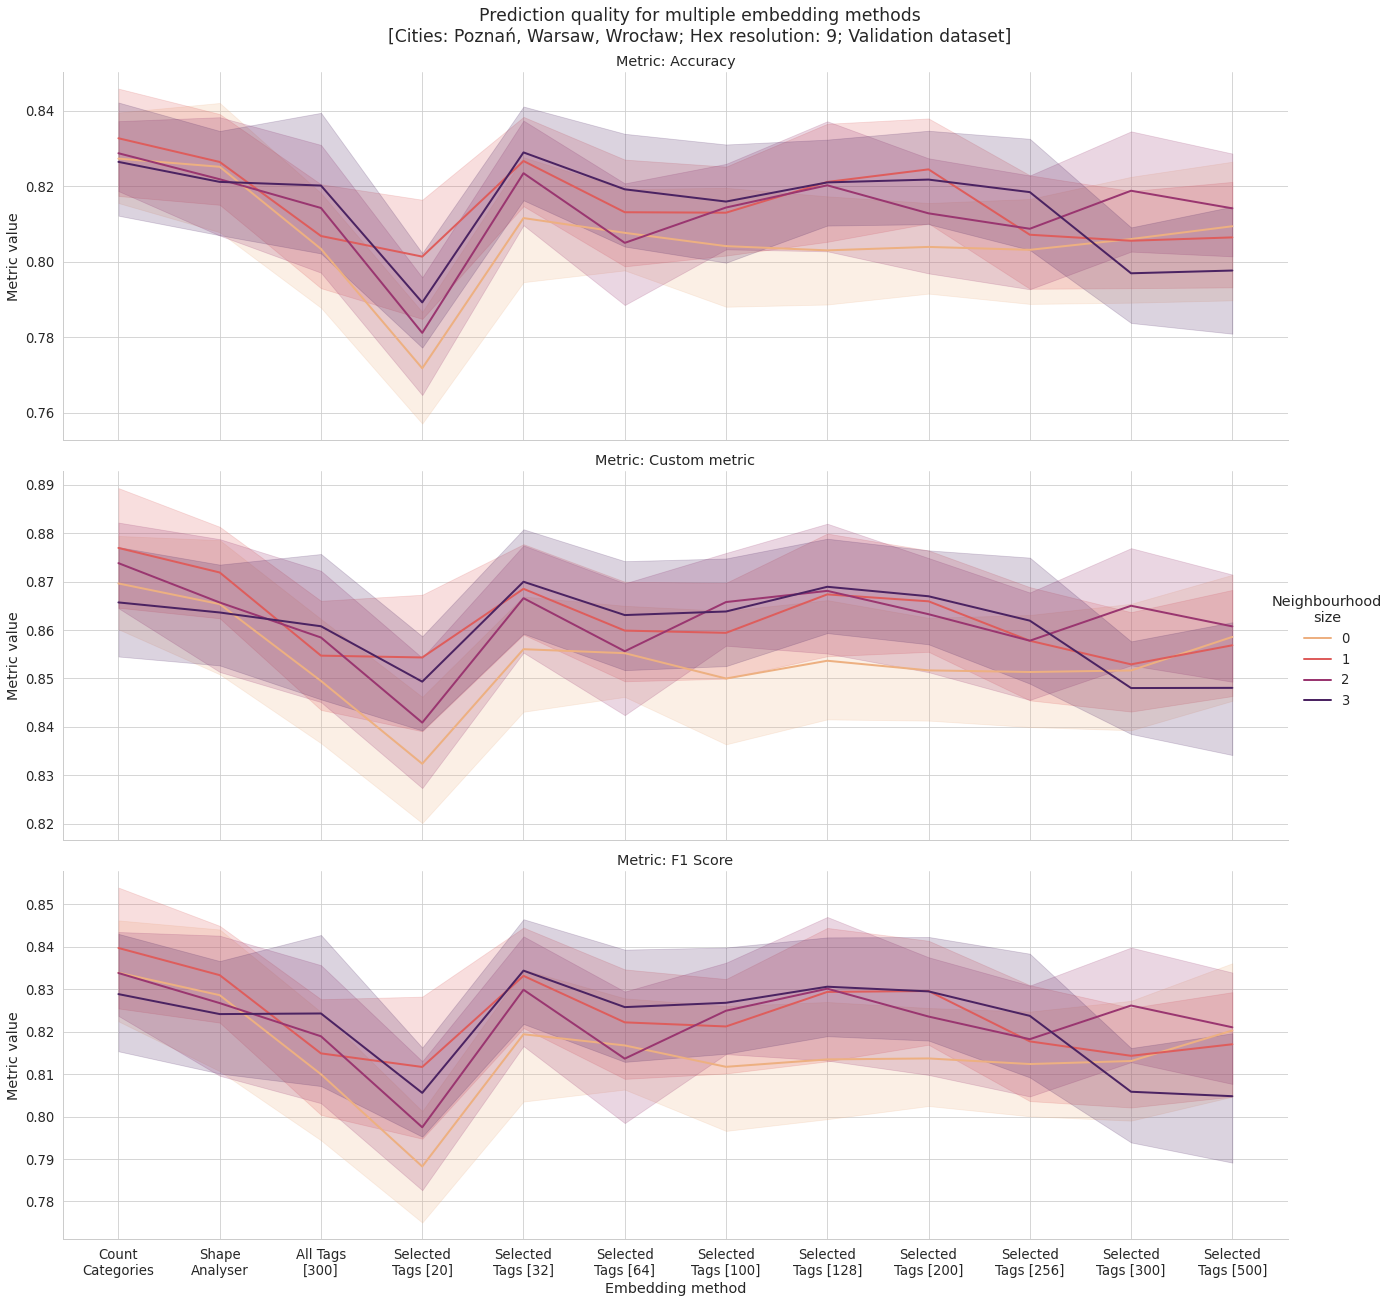

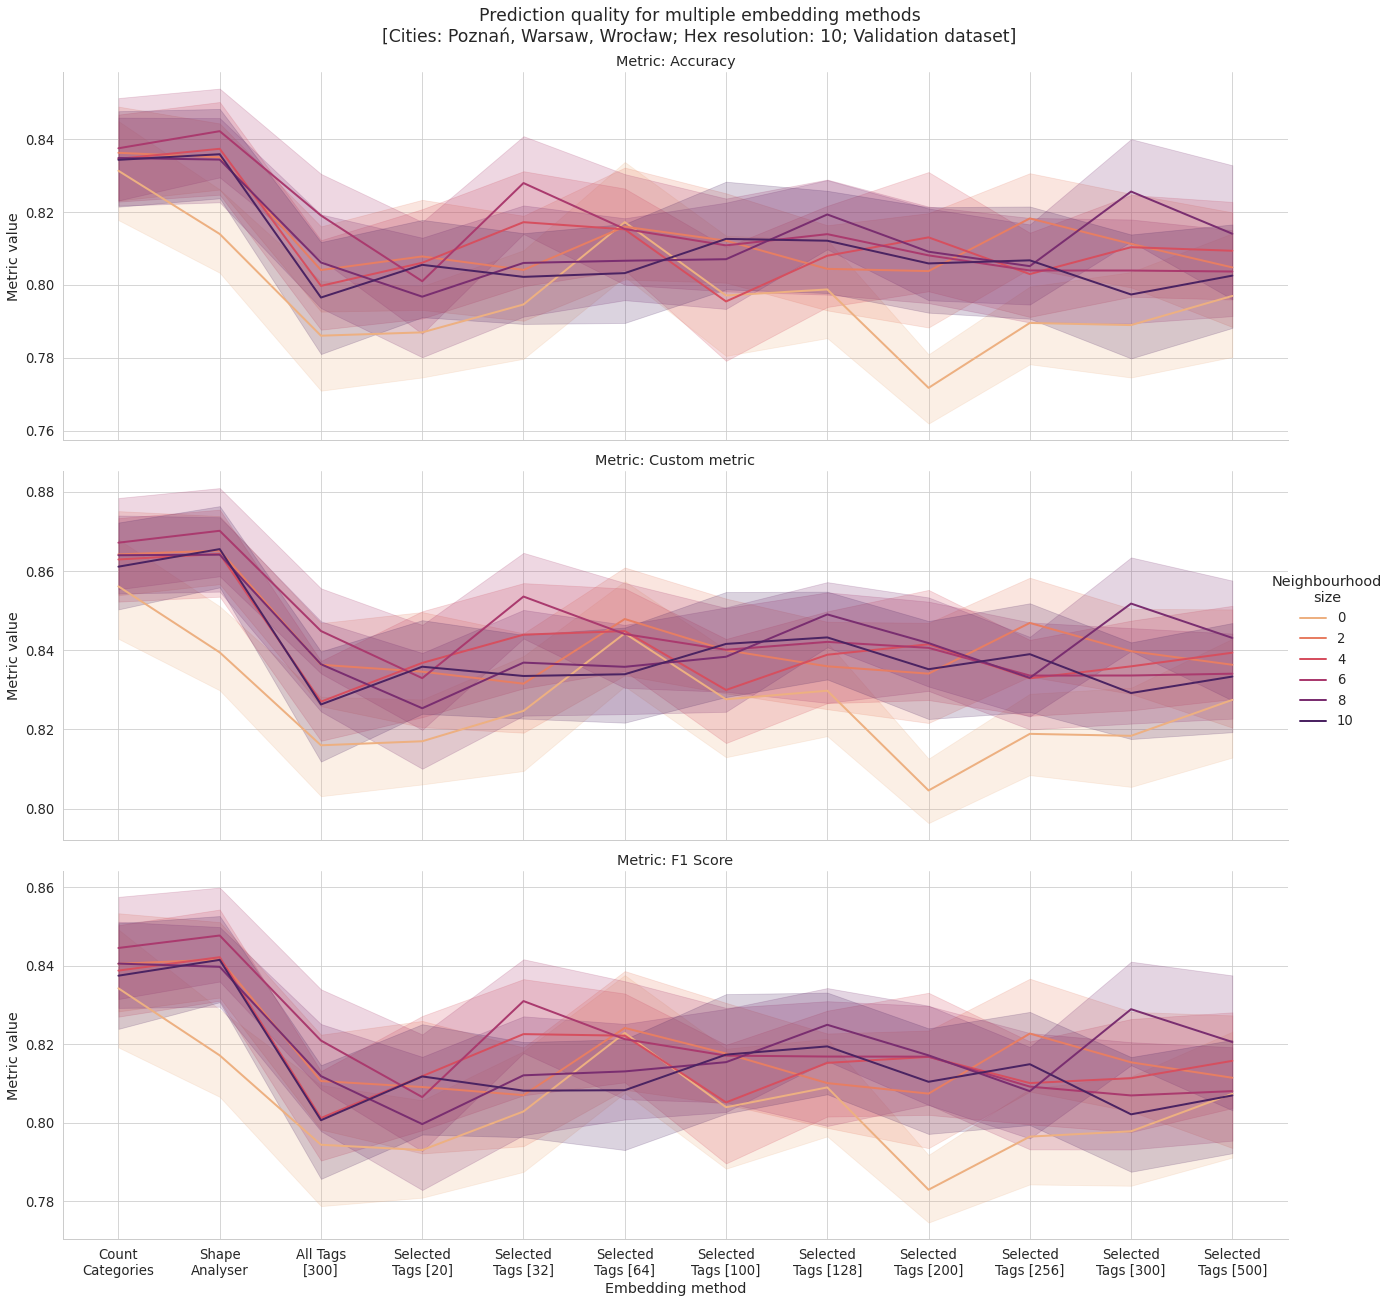

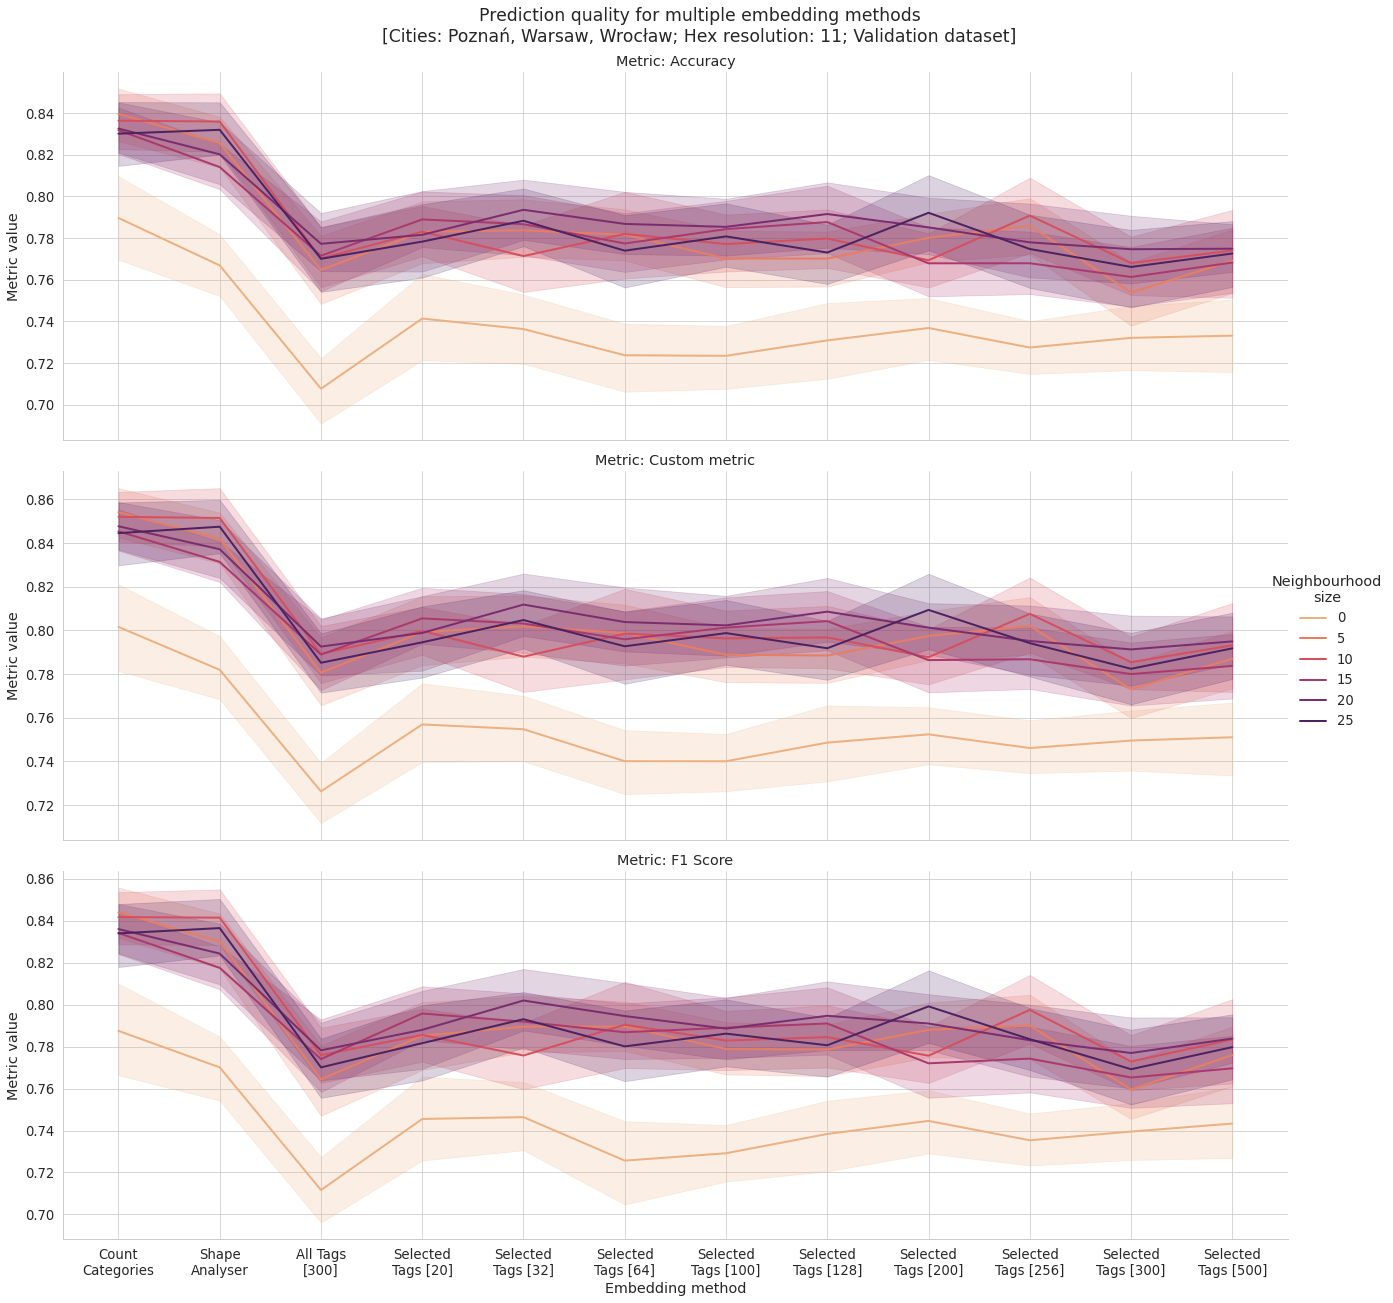

In [51]:
# sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 4})
# sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 2})
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2})
# with sns.plotting_context(font_scale=1.5):
for res in [9, 10, 11]:
# for metric in ['f1_score', 'accuracy', 'custom_metric']:
    filtered_df = df_flat.loc[
        # (df_flat.city == 'Wrocław') \
        (df_flat.resolution == res) \
        # (df_flat.resolution == res) \
        & (df_flat.dataset_type == 'validation') \
        # & (df_flat.neighbours > 0) \
        & (df_flat.inbalance_ratio == 1) \
        & (df_flat.classfier_cls == 'RandomForestClassifier')
    ]
    filtered_df['emb_cls'] = filtered_df.embedding_cls.astype(str)
    a = np.arange(len(filtered_df.embedding_cls.unique()))
    # g = sns.violinplot(data=filtered_df,
    #     y="value",AdaBoostClassifier
    #     x="embedding_cls")
    g = sns.relplot(
        data=filtered_df,
        x="clf_emb_num",
        # x="value",
        # x="emb_cls",
        # x=a,
        # order="embedding_cls",
        y="value",
        # y="embedding_cls",
        hue="neighbours",
        # hue="classfier_cls",
        # size="choice",
        # col="align",
        kind="line",
        # kind="scatter",
        row="metric",
        # size_order=["T1", "T2"],
        # palette=palette,
        palette="flare",
        height=6, aspect=3,
        facet_kws=dict(sharex=True, sharey=False),
        orient="h"
    )
    # g = sns.catplot(
    #     data=filtered_df,
    #     y="value",
    #     x="embedding_cls",
    #     hue="neighbours",
    #     # hue="inbalance_ratio",
    #     # hue="classfier_cls",
    #     # kind="box",
    #     kind="violin",
    #     # split=True,
    #     row="metric",
    #     height=6, aspect=2.5);
    # g = sns.displot(
    #     data=filtered_df, x="value", 
    #     hue="neighbours", 
    #     # hue="processing", 
    #     # hue="inbalance_ratio", 
    #     row="embedding_cls", col="metric",
    #     # facet_kws=dict(row_order=['Concatenate', 'Average', 'Average Diminishing', 'Average Diminishing Squared']),
    #     kind="kde", height=6, aspect=0.8, palette="flare"
    # )

    # # iterate over axes of FacetGrid
    for ax in g.axes.flat:
        # labels = ax.get_xticklabels() # get x labels
        # for i,l in enumerate(labels):
        #     if(i%2 == 0): labels[i] = '' # skip even labels
        ax.set(xticks=list(embedding_clf_dict.values()))
        ax.set_xticklabels(list(embedding_clf_dict_rev.values())) # set new labels

    # ax2.plot(a, y) #we plot y as a function of a, which parametrizes x
    # g. set_ticks(a) #set the ticks to be a
    # g.set_ticklabels(filtered_df['emb_cls']) # change the ticks' names to x

    # g.set(xticks=a, xticklabels=filtered_df['emb_cls'])
    # plt.ylim(0, 1)

    # g.set_axis_labels("Density", f"Metric: {metric}")
    # g.map(vertical_mean_line_base, 'value', color='k', ls='--', alpha=0.5)
    g.set_axis_labels("Embedding method", "Metric value")
    g.set_titles("Metric: {row_name}")
    # g.set_titles("{row_name}\nMetric: {col_name}")

    # g.fig.subplots_adjust(wspace=0.1, hspace=0.3)
    g.fig.subplots_adjust(top=0.93) # adjust the Figure in rp
    g.fig.suptitle(f'Prediction quality for multiple embedding methods\n[Cities: Poznań, Warsaw, Wrocław; Hex resolution: {res}; Validation dataset]')

    # plt.legend(title='Neighbourhood size')
    g._legend.set_title("Neighbourhood\nsize")
    g._legend.get_title().set_multialignment('center')
    # plt.tight_layout()

    # plt.savefig(f'embedding_methods_{res}.pdf', dpi=300, format='pdf', bbox_inches='tight')

<ipython-input-111-709ae9380da5>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['emb_cls'] = filtered_df.embedding_cls.astype(str)


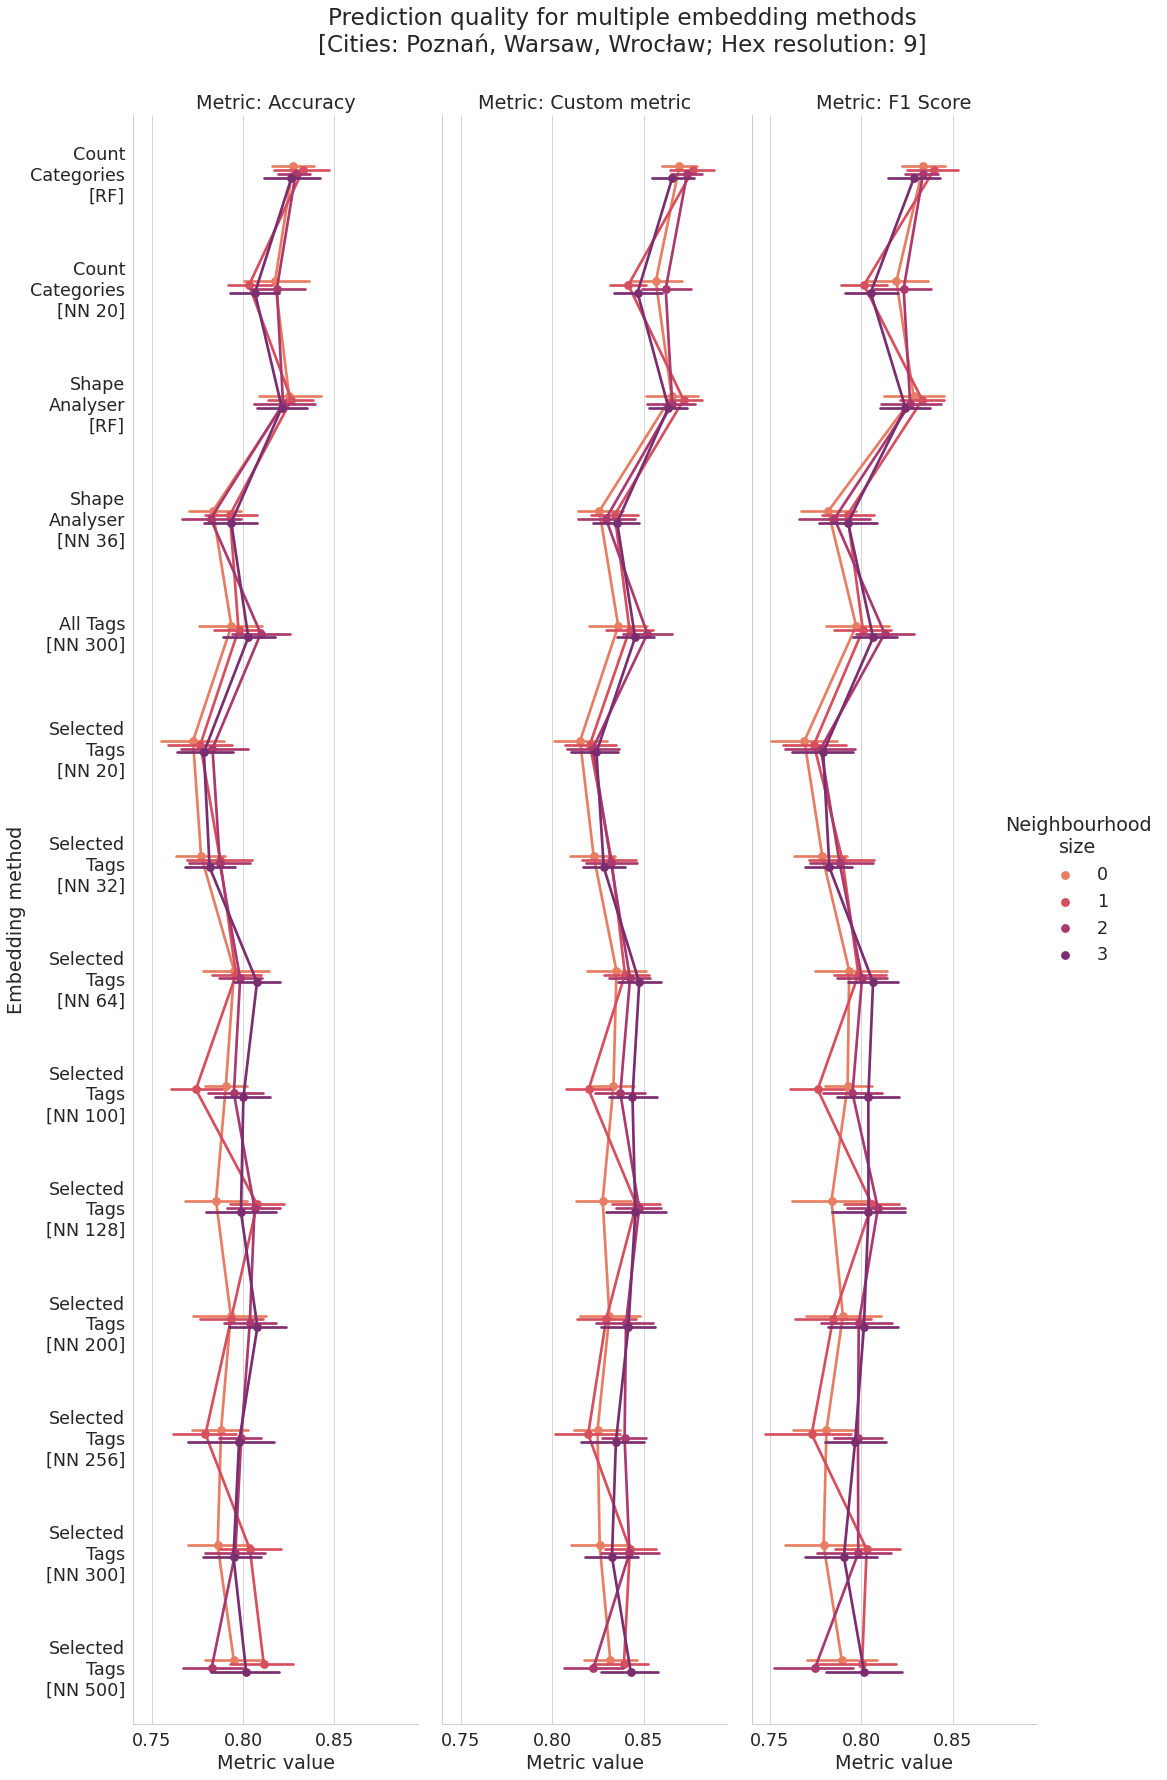

<ipython-input-111-709ae9380da5>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['emb_cls'] = filtered_df.embedding_cls.astype(str)


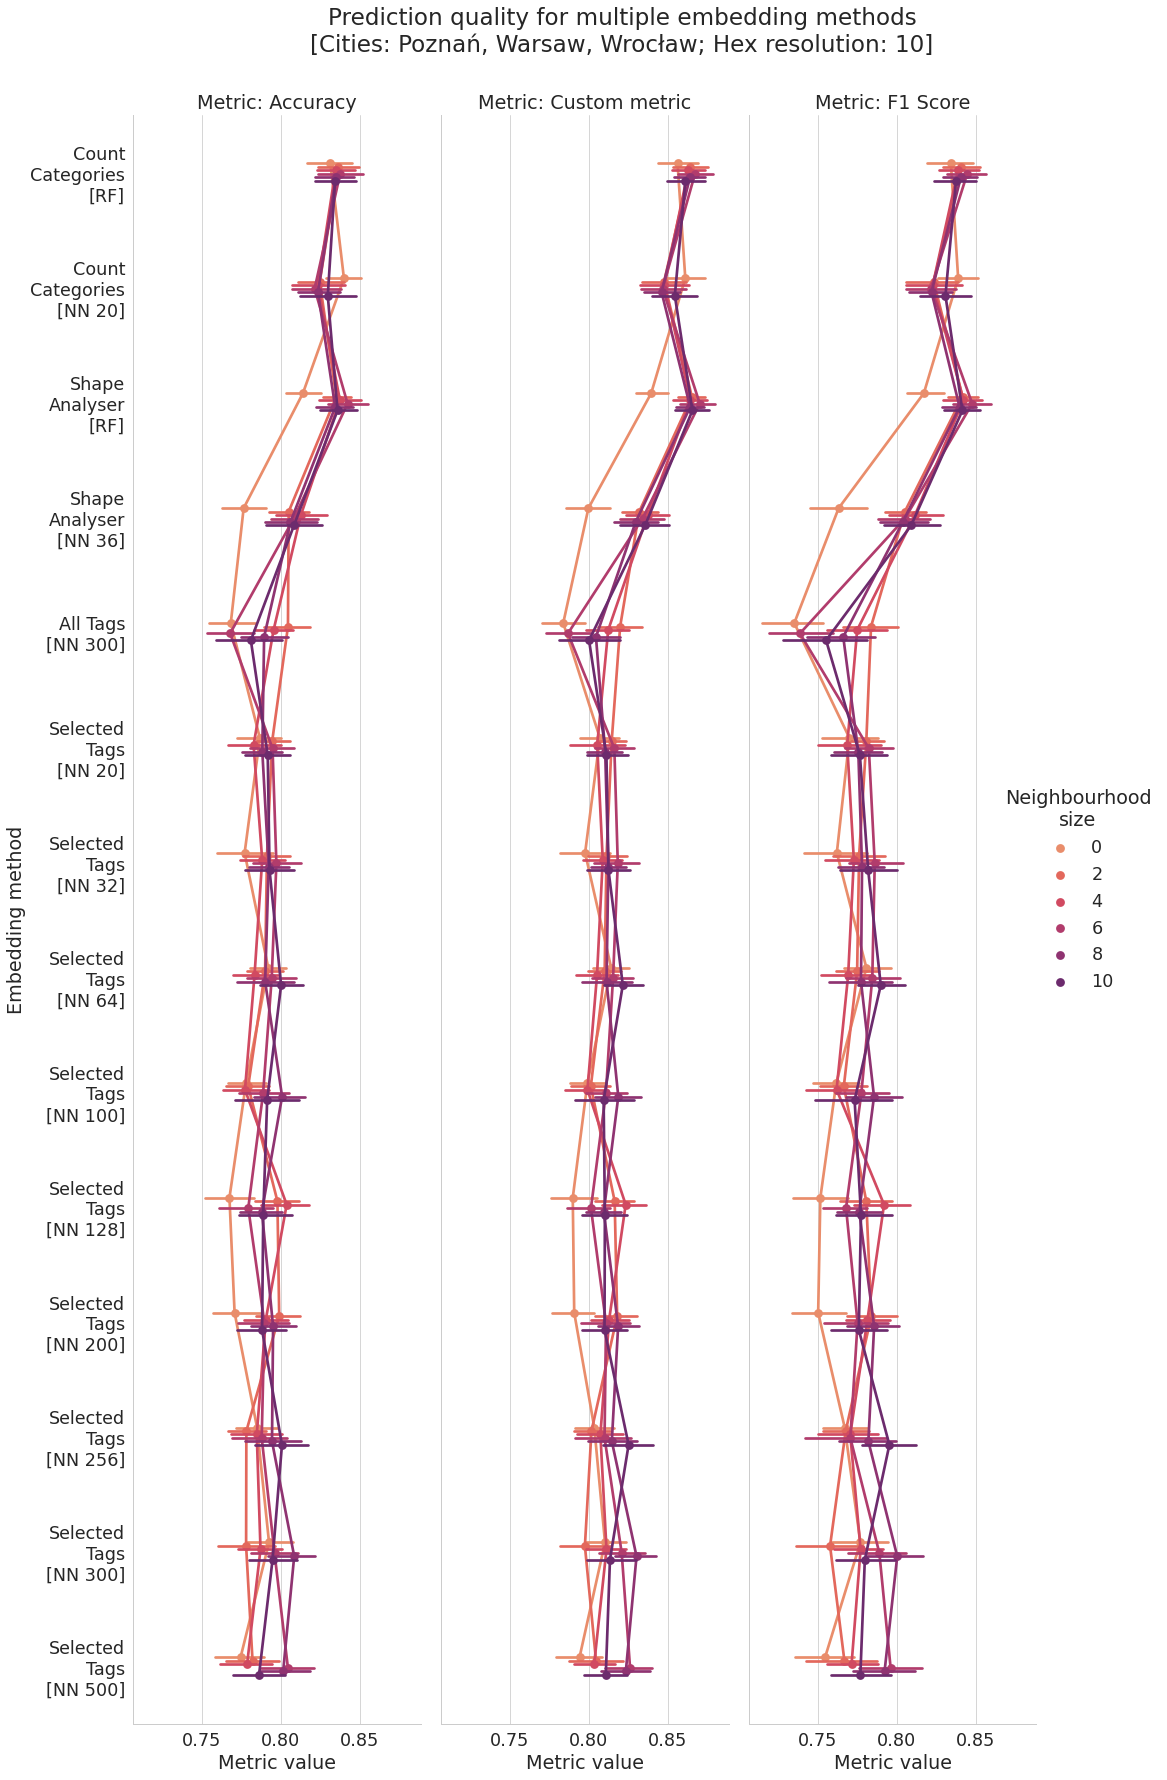

<ipython-input-111-709ae9380da5>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['emb_cls'] = filtered_df.embedding_cls.astype(str)


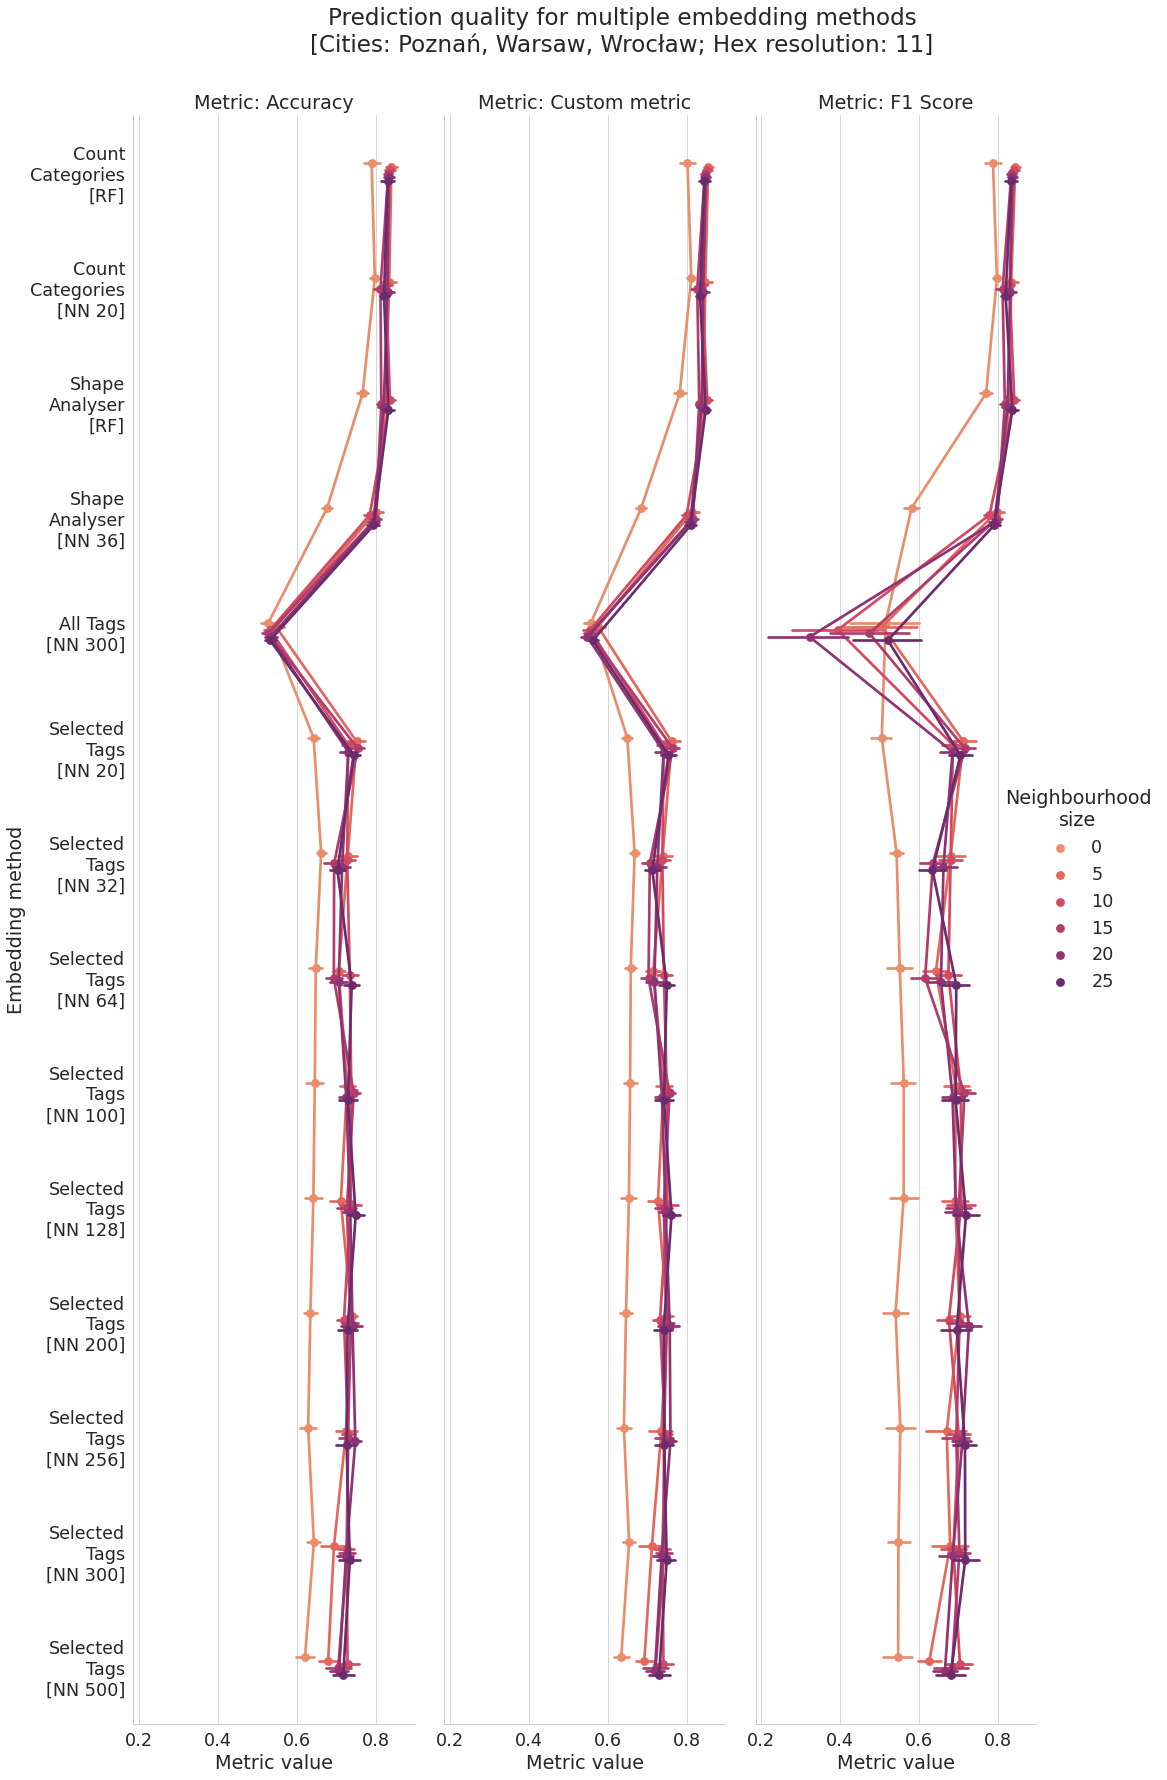

In [111]:
# sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 4})
# sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 2})
sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 1.5})
# with sns.plotting_context(font_scale=1.5):
for res in [9, 10, 11]:
# for metric in ['f1_score', 'accuracy', 'custom_metric']:
    # fig = plt.figure(figsize=(8.25, 11.75))
    filtered_df = df_flat.loc[
        # (df_flat.city == 'Wrocław') \
        (df_flat.resolution == res) \
        # (df_flat.resolution == res) \
        & (df_flat.dataset_type == 'validation') \
        # & (df_flat.neighbours > 0) \
        & (df_flat.inbalance_ratio == 1) \
        # & (df_flat.classfier_cls == 'RandomForestClassifier')
    ]
    filtered_df['emb_cls'] = filtered_df.embedding_cls.astype(str)
    a = np.arange(len(filtered_df.embedding_cls.unique()))
    # g = sns.violinplot(data=filtered_df,
    #     y="value",AdaBoostClassifier
    #     x="embedding_cls")
    g = sns.catplot(
        data=filtered_df,
        # x="embedding_cls",
        x="value",
        # x="emb_cls",
        # x=a,
        # order="embedding_cls",
        # y="value",
        y="clf_emb_num",
        # y="embedding_cls",
        hue="neighbours",
        # linewidth=0,
        # hue="classfier_cls",
        # size="choice",
        # col="align",
        kind="point",
        dodge=True,
        # capsize=.1,
        # kind="violin",
        # kind="scatter",
        # row="metric",
        col="metric",
        # size_order=["T1", "T2"],
        # palette=palette,
        palette="flare",
        height=25, aspect=.18,
        facet_kws=dict(sharex=False, sharey=True),

        orient="h"
    )

    # # iterate over axes of FacetGrid
    for ax in g.axes.flat:
        # labels = ax.get_xticklabels() # get x labels
        # for i,l in enumerate(labels):
        #     if(i%2 == 0): labels[i] = '' # skip even labels
        # ax.set(yticks=list(embedding_cls_dict.values()))

        ax.set_yticklabels(list(embedding_clf_dict_rev.values())) # set new labels
        pass

    # ax2.plot(a, y) #we plot y as a function of a, which parametrizes x
    # g. set_ticks(a) #set the ticks to be a
    # g.set_ticklabels(filtered_df['emb_cls']) # change the ticks' names to x

    # g.set(xticks=a, xticklabels=filtered_df['emb_cls'])
    # plt.ylim(0, 1)

    # g.set_axis_labels("Density", f"Metric: {metric}")
    # g.map(vertical_mean_line_base, 'value', color='k', ls='--', alpha=0.5)
    # g.set_axis_labels("Embedding method", "Metric value")
    g.set_axis_labels("Metric value", "Embedding method")
    g.set_titles("Metric: {col_name}")
    # g.set_titles("{row_name}\nMetric: {col_name}")

    # g.fig.subplots_adjust(wspace=0.1, hspace=0.3)
    g.fig.subplots_adjust(top=0.92) # adjust the Figure in rp
    g.fig.suptitle(f'Prediction quality for multiple embedding methods\n[Cities: Poznań, Warsaw, Wrocław; Hex resolution: {res}]')

    # plt.legend(title='Neighbourhood size')
    g._legend.set_title("Neighbourhood\nsize")
    g._legend.get_title().set_multialignment('center')
    # plt.tight_layout()

    plt.savefig(f'embedding_methods_2_{res}.pdf', dpi=300, format='pdf', bbox_inches='tight')
    plt.show()